<a href="https://colab.research.google.com/github/mahima-c/GAN-Generative-Adversarial-Networks/blob/main/6_2DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**DCGAN for MNIST digits**


In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

The GAN is trained in the same manner as before; first random noise is fed to the generator. The output of the generator is added with real images to initially train the discriminator, and then the generator is trained to give an image that can fool the discriminator. The process is repeated for the next batch of images. The GAN takes between a few hundred to thousands of epochs to train:

In [4]:
class DCGAN():
    def __init__(self, rows, cols, channels, z = 10):
        # Input shape
        self.img_rows = rows
        self.img_cols = cols
        self.channels = channels
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = z

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=256, save_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        # fig.savefig("images/dcgan_mnist_%d.png" % epoch)
        plt.close()

Let us now train our GAN:



In [ ]:
dcgan = DCGAN(28,28,1)
dcgan.train(epochs=4000, batch_size=32, save_interval=50)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 64)         

In [8]:
dcgan.generator.save("DCGAN.h5")


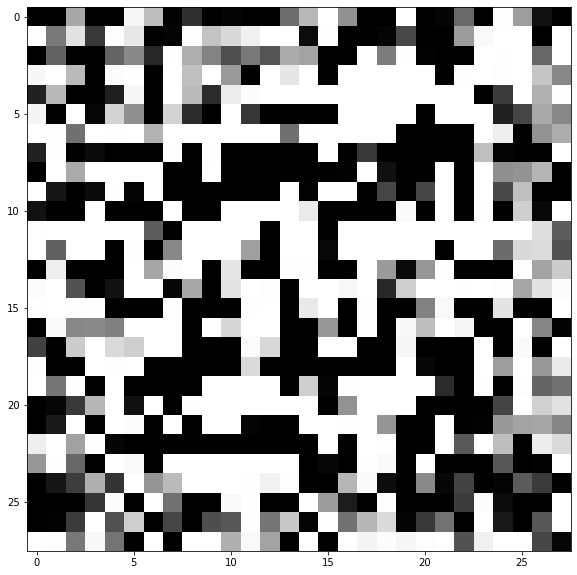

In [13]:
examples=100
noise = np.random.normal(0, 1, (1, 10))
gen_imgs = dcgan.generator.predict(noise)
generatedImages = gen_imgs.reshape( 28, 28)
figsize=(10, 10)
plt.figure(figsize=figsize)
   
plt.imshow(generatedImages, interpolation='nearest', cmap='gray_r')